In [1]:
import pandas as pd
import shap
import joblib
from catboost import Pool
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Open the pickle file in read-binary mode
with open("../models/needed_variables.pkl", "rb") as f:
    df = joblib.load(f)

In [3]:
X = df["X_test"]
y = df["y_test"]

In [4]:
with open("../models/step2_catboost_timesplit.pkl", "rb") as f:
    model = joblib.load(f)

## SHAP Feature Importance

In [5]:
# Create CatBoost Pool
pool = Pool(data=X, label=y)

# Get SHAP values (last column = base value)
shap_values = model.get_feature_importance(type="ShapValues", data=pool)

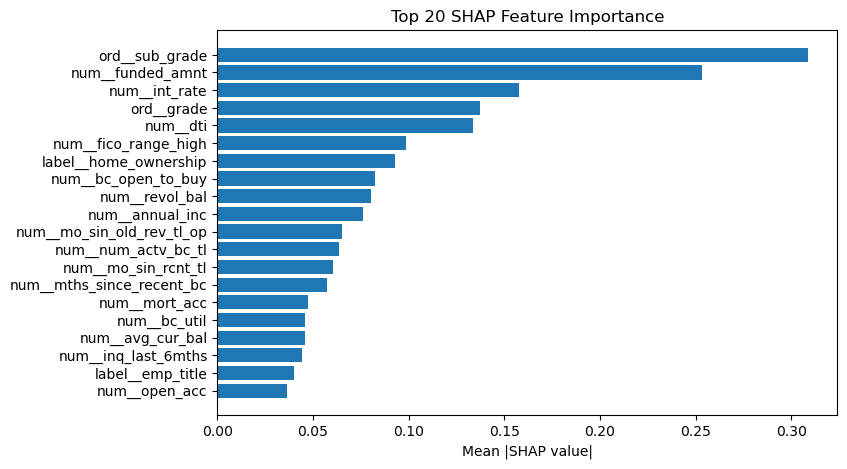

In [6]:
# Compute mean |SHAP| importance
feature_importance = np.abs(shap_values[:, :-1]).mean(axis=0)
feature_names = X.columns
sorted_idx = np.argsort(feature_importance)[::-1]

# Keep only top 20
top_n = 20
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8, 5))
plt.barh([feature_names[i] for i in top_idx], feature_importance[top_idx])
plt.xlabel("Mean |SHAP value|")
plt.title(f"Top {top_n} SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()

## SHAP Force Plot

In [7]:
shap.initjs()

# Pick one observation
index_to_explain = 0
single_X = X.iloc[[index_to_explain]]

# Extract SHAP values and base value for this observation
single_shap_values = shap_values[index_to_explain, :-1]
base_value = shap_values[index_to_explain, -1]

# Interactive force plot
shap.force_plot(base_value, single_shap_values, single_X)

In [8]:
# Create force plot
force_plot = shap.force_plot(base_value, single_shap_values, single_X)

# Save to HTML
shap.save_html("force_plot.html", force_plot)
print("Force plot saved as force_plot.html")

Force plot saved as force_plot.html


## SHAP Waterfall Plot

findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


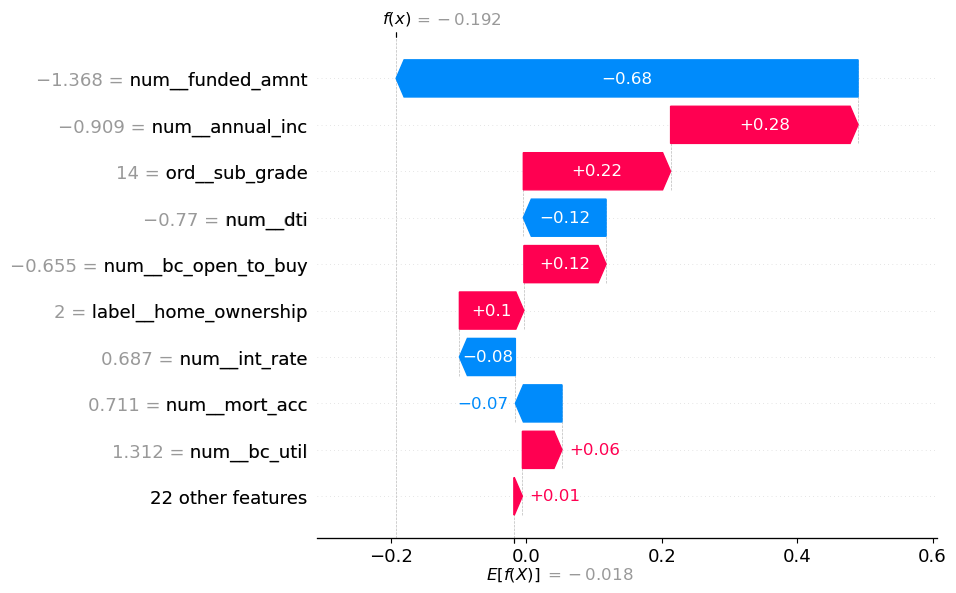

In [9]:
# Waterfall plot
shap.plots.waterfall(
    shap.Explanation(
        values=single_shap_values,
        base_values=base_value,
        data=single_X.values[0],
        feature_names=single_X.columns.tolist(),
    )
)

## SHAP Summary Plot

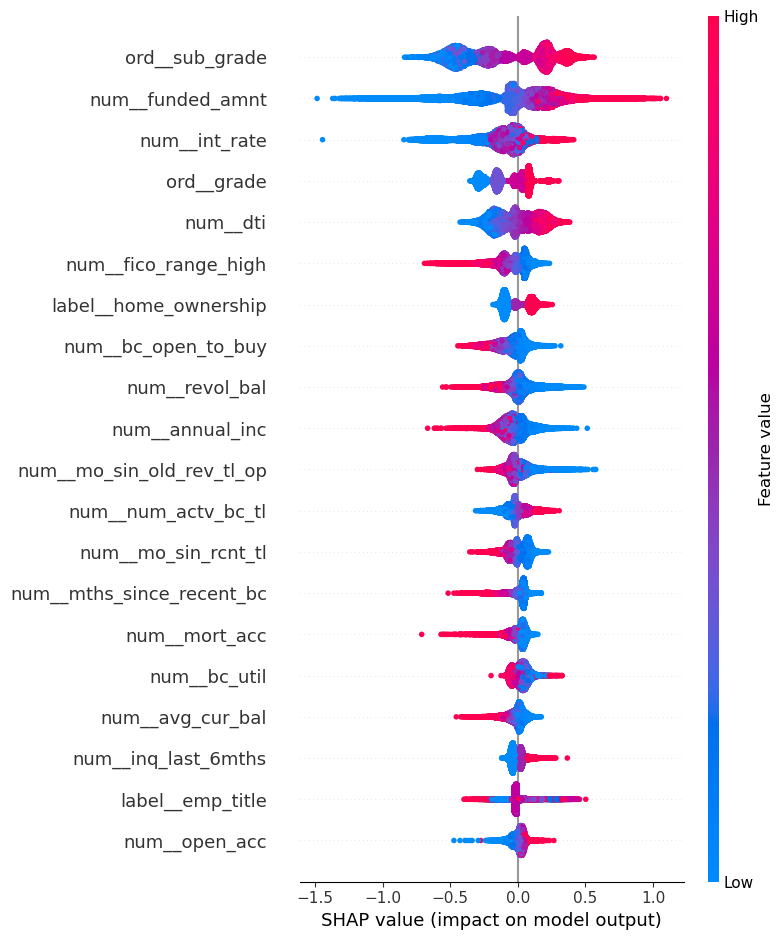

In [10]:
# SHAP summary plot
shap.summary_plot(shap_values[:, :-1], X)